# 1. <a id='toc1_'></a>[Bayesian Filters for Multivariate Time Series Prediction](#toc0_)

[![GitLab issues by label](https://img.shields.io/badge/Status-Depricated_for_Darts-blue)](https://git.informatik.uni-kiel.de/gaf/enhanced-cpa/-/issues/15)

**Table of contents**<a id='toc0_'></a>    
1. [Bayesian Filters for Multivariate Time Series Prediction](#toc1_)    
1.1. [Dependencies](#toc1_1_)    
1.2. [Toy trajectories](#toc1_2_)    
1.3. [Kalman Filters](#toc1_3_)    
1.3.1. [Kalman Filter](#toc1_3_1_)    
1.3.2. [Using pykalman and microprediction](#toc1_3_2_)    
1.3.3. [Extended Kalman Filter](#toc1_3_3_)    
1.3.4. [Ensemble Kalman Filter](#toc1_3_4_)    
1.3.5. [Unscented Kalman Filter](#toc1_3_5_)    
1.3.6. [Example](#toc1_3_6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
%load_ext autoreload
%autoreload 2

## 1.1. <a id='toc1_1_'></a>[Dependencies](#toc0_)

In [ ]:
import numpy as np

from filterpy.kalman import KalmanFilter, ExtendedKalmanFilter, EnsembleKalmanFilter, UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

from geopy.distance import geodesic

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
cmap = cm.coolwarm

## 1.2. <a id='toc1_2_'></a>[Toy trajectories](#toc0_)

In [ ]:
# Generate example data
def generate_example_data(start_pos, num_points_straight, num_points_curve):
    lat, lon = start_pos
    SOG = []
    COG = []
    positions = [(lat, lon)]
    
    # Straight line navigation
    for i in range(num_points_straight):
        SOG.append(10 + np.random.randn() * 0.5)  # Speed in knots
        COG.append(90)  # Course in degrees (east)
        distance = SOG[-1] * 1.852 / 3600  # Convert knots to km
        new_pos = geodesic(kilometers=distance).destination(positions[-1], COG[-1])
        positions.append((new_pos.latitude, new_pos.longitude))
    
    # Curved maneuver navigation
    for i in range(num_points_curve):
        SOG.append(10 + np.random.randn() * 0.5)  # Speed in knots
        COG.append(90 + 20*i)  # Gradually changing course
        distance = SOG[-1] * 1.852 / 3600  # Convert knots to km
        new_pos = geodesic(kilometers=distance).destination(positions[-1], COG[-1])
        positions.append((new_pos.latitude, new_pos.longitude))
        
    # Curved maneuver navigation
    for i in range(num_points_curve):
        SOG.append(10 + np.random.randn() * 0.5)  # Speed in knots
        COG.append(-90 - 10*i)  # Gradually changing course
        distance = SOG[-1] * 1.852 / 3600  # Convert knots to km
        new_pos = geodesic(kilometers=distance).destination(positions[-1], COG[-1])
        positions.append((new_pos.latitude, new_pos.longitude))
    
    return SOG, COG, positions

# Plot the navigation on a map
def plot_navigation(positions, speeds=None, prediction=False, fig=None, ax=None):
    lats, lons = zip(*positions)
    
    ## Plot using Cartopy >>
    if fig is None or ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    # ax.add_feature(cfeature.COASTLINE)
    # ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    if not prediction:  # Plot the actual navigation
        ax.scatter(lons, lats, color='blue', marker='o', alpha=0.7, transform=ccrs.PlateCarree(), zorder=1)
        # for i, (lat, lon) in enumerate(positions):
        #     ax.text(lon + 0.1, lat + 0.1, f"Point {i+1}", color='blue', transform=ccrs.PlateCarree(), fontsize=10, zorder=3)
        
        # Color map based on speeds
        if speeds is None:
            ax.plot(lons, lats, color='cyan', linewidth=2, alpha=0.9, transform=ccrs.PlateCarree(), zorder=2)
        else:
            for i in range(len(positions)-1):
                ax.plot([lons[i], lons[i+1]], [lats[i], lats[i+1]], color=cmap(speeds[i]/np.max(speeds)), linewidth=2, alpha=0.9, transform=ccrs.PlateCarree(), zorder=2)
                
        ax.set_title('Ship Navigation in Kiel Fjord', fontsize=15)
        ax.set_extent([np.min(lons)-1E-4, np.max(lons)+1E-4, np.min(lats)-1E-4, np.max(lats)+1E-4], crs=ccrs.PlateCarree())  # Adjust based on your data extent
        
    if prediction:  # Plot the predicted navigation
        ax.scatter(lons, lats, color='red', marker='x', alpha=0.7, transform=ccrs.PlateCarree(), zorder=1)
        # for i, (lat, lon) in enumerate(positions):
        #     ax.text(lon + 0.1, lat + 0.1, f"Point {i+1}", color='blue', transform=ccrs.PlateCarree(), fontsize=10, zorder=3)
        
        # Color map based on speeds
        if speeds is None:
            ax.plot(lons, lats, color='green', linewidth=2, alpha=0.9, transform=ccrs.PlateCarree(), zorder=2)
        else:
            for i in range(len(positions)-1):
                ax.plot([lons[i], lons[i+1]], [lats[i], lats[i+1]], '--' , color=cmap(speeds[i]/np.max(speeds)), linewidth=2, alpha=0.9, transform=ccrs.PlateCarree(), zorder=2)
                
        ax.set_title('Ship Navigation in Kiel Fjord', fontsize=15)
        ax.set_extent([np.min(lons)-1E-4, np.max(lons)+1E-4, np.min(lats)-1E-4, np.max(lats)+1E-4], crs=ccrs.PlateCarree())  # Adjust based on your data extent
    
        
    # Create a colorbar for speeds
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(speeds), vmax=np.max(speeds)))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, orientation='horizontal', label='Speed (knots)')
    
    return fig, ax

In [ ]:
# Example usage
start_pos = (54.321, 10.134)  # Example starting position in Kiel Fjord
num_points_straight = 10
num_points_curve = 10

SOG, COG, positions = generate_example_data(start_pos, num_points_straight, num_points_curve)

plot_navigation(positions, SOG, prediction=True)

In [ ]:
## Leave the last 7 points for test >>
num_predictions = 5
start_pos = positions[0]

positions_train, SOG_train, COG_train = positions[:-num_predictions], SOG[:-num_predictions], COG[:-num_predictions]
positions_test, SOG_test, COG_test = positions[-num_predictions::], SOG[-num_predictions::], COG[-num_predictions::]

## 1.3. <a id='toc1_3_'></a>[Kalman Filters](#toc0_)

Here the following are considered:
1. Kalman Filter
2. Extended Kalman Filter
3. ~~Ensemble Kalman Filter~~
4. Unscented Kalman Filter

### 1.3.1. <a id='toc1_3_1_'></a>[Kalman Filter](#toc0_)

 - Method: A linear, recursive estimator used to produce an optimal estimate of an unknown quantity based on a series of measurements over time.
 - Pros:
     - Fast and computationally efficient for linear systems.
     - Provides optimal solutions when the system dynamics are known and the noise is Gaussian.
 - Cons:
     - Assumes linear dynamics and Gaussian noise, which may not always hold true in real-world scenarios.
     - Limited to linear systems.

### 1.3.2. <a id='toc1_3_2_'></a>[Using pykalman and microprediction](#toc0_)

<p align="right">
    [<a href=https://medium.com/@mike.roweprediger/using-the-filterpy-package-for-time-series-prediction-d8969b9bf5c6>
        <i>source</i>
    </a>]
</p>

In [ ]:
from pykalman import KalmanFilter
from typing import List, Tuple, Dict, Any, Callable

In [50]:
def predict_kalman_new(SOG: List[float],
                   COG: List[float],
                   POS: List[Tuple[float, float]],
                   num_predictions: int,
                   max_iter: int = 10) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Predicts future states using the Kalman Filter algorithm.

    Args:
        SOG (List[float]): List of Speed Over Ground measurements.
        COG (List[float]): List of Course Over Ground measurements.

        
        num_predictions (int): Number of future state predictions to make.
        max_iter (int, optional): Maximum number of iterations for the EM algorithm. Defaults to 10.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Tuple containing the predicted Speed Over Ground, Course Over Ground, and positions.
    """
    
    ## Variables >>
    "EM algorithm is that the algorithm lacks regularization, meaning that parameter values may diverge to infinity in order to make the measurements more likely."
    "Thus it is important to choose which parameters to optimize via the em_vars parameter of KalmanFilter."
    em_vars=['transition_matrices', 'transition_covariance', 'observation_matrices', 'observation_covariance']
    measurements = np.column_stack([SOG, COG])  # Stack the SOG and COG measurements
    positions = np.asarray(POS)  # Convert positions to numpy array
    start_pos = positions[-1]  # Get the last point of the training positions as the starting position for prediction
    
    # ToDo(1): Change the time stamps to be in DateTime
    # ToDo(2): Here the time stamps are assumed to be equidistanced. For that an interpolation must be included in the predictor.
    # delta_t = time_stamps[-1] - time_stamps[-2]  # Calculate the time difference between the last two time stamps
    
    ## Initialize Kalman Filter >>
    initial_state_mean = [SOG[0], COG[0]]
    transition_matrix = np.eye(len(initial_state_mean))
    observation_matrix = [[1, 0], [0, 1]]
    
    kf = KalmanFilter(
        initial_state_mean=initial_state_mean,
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrix,
        n_dim_obs=2)  # n_dim_obs: number of observations space    
    
    ## Find the best number of iterations for the EM algorithm using the parameter change criterion >>
    best_n_iter = None
    best_parameter_change = float('inf')

    for n_iter in range(1, max_iter):
        # Perform the filtering and smoothing
        _kf = KalmanFilter(
            initial_state_mean=initial_state_mean,
            transition_matrices=transition_matrix,
            observation_matrices=observation_matrix,
            n_dim_obs=2)
        # _kf = _kf.em(measurements, n_iter=n_iter)
        _kf = _kf.em(measurements, n_iter=n_iter, em_vars=em_vars)
        smoothed_state_means, smoothed_state_covariances = _kf.smooth(measurements)
        filtered_state_means, filtered_state_covariances = _kf.filter(measurements)

        # Calculate the parameter change
        parameter_change = np.sum(np.abs(smoothed_state_means - filtered_state_means))

        # Check if this is the best fit so far
        if parameter_change < best_parameter_change:
            best_n_iter = n_iter
            best_parameter_change = parameter_change

    if best_n_iter is not None:
        print("Best n_iter:", best_n_iter)
    else:
        print("Best n_iter is None, using max_iter instead.")
        best_n_iter = max_iter
    
    
    ## Fit the Kalman Filter to the data with the best_n_iter >>
    # kf = kf.em(measurements, n_iter=best_n_iter)
    kf = kf.em(measurements, n_iter=5, em_vars=em_vars)  # n_iter: number of iterations or steps used in the expectation-maximization (EM) algorithm.
    (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    # print(filtered_state_means)
    
    # Predict future states
    # future_state_means, future_state_covariances = kf.filter_update(filtered_state_means[-1], 
    #                                                                 filtered_state_covariances[-1])
    # future_state_means: list = []
    # future_state_covariances: list = [] 
    _predicted_SOG = []
    _predicted_COG = []
    _predicted_positions = [tuple(start_pos)]

    
    
    
    for i in range(num_predictions):
        # future_state_means, future_state_covariances = kf.filter_update(future_state_means[-1], 
        #                                                                 future_state_covariances[-1])
        
        future_state_means, future_state_covariances = kf.filter_update(filtered_state_means[-1], 
                                                                    filtered_state_covariances[-1])
        
        if i == 4:
            print(future_state_means)
        
        _predicted_SOG.append(future_state_means[0])
        _predicted_COG.append(future_state_means[1])
        
        # Calculate new position
        distance = future_state_means[0] * 1.852 / 3600  # Convert knots to km
        bearing = future_state_means[1]
        new_pos = geodesic(kilometers=distance).destination(_predicted_positions[-1], bearing)
        _predicted_positions.append((new_pos.latitude, new_pos.longitude))
    
    # Convert the lists into numpy arrays
    predicted_SOG = np.array(_predicted_SOG)
    predicted_COG = np.array(_predicted_COG)
    predicted_positions = np.array(_predicted_positions) # np.array(_predicted_positions[1::]) 
    
    return predicted_SOG, predicted_COG, predicted_positions

In [48]:
def predict_kalman(SOG: List[float], COG: List[float], POS: List[Tuple[float, float]], num_predictions: int, max_iter: int = 10) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Predicts future states using the Kalman Filter algorithm.

    Args:
        SOG (List[float]): List of Speed Over Ground measurements.
        COG (List[float]): List of Course Over Ground measurements.
        start_pos (Tuple[float, float]): Starting position coordinates (latitude, longitude).
        num_predictions (int): Number of future state predictions to make.
        max_iter (int, optional): Maximum number of iterations for the EM algorithm. Defaults to 10.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Tuple containing the predicted Speed Over Ground, Course Over Ground, and positions.
    """
    
    ## Variables >>
    "EM algorithm is that the algorithm lacks regularization, meaning that parameter values may diverge to infinity in order to make the measurements more likely."
    "Thus it is important to choose which parameters to optimize via the em_vars parameter of KalmanFilter."
    em_vars=['transition_matrices', 'transition_covariance', 'observation_matrices', 'observation_covariance']
    measurements = np.column_stack([SOG, COG])  # Stack the SOG and COG measurements
    positions = np.asarray(POS)  # Convert positions to numpy array
    start_pos = positions[-1]  # Get the last point of the training positions as the starting position for prediction
    
    
    ## Initialize Kalman Filter >>
    initial_state_mean = [SOG[0], COG[0]]
    transition_matrix = [[1, 0], [0, 1]]
    observation_matrix = [[1, 0], [0, 1]]
    
    kf = KalmanFilter(
        initial_state_mean=initial_state_mean,
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrix,
        n_dim_obs=2)  # n_dim_obs: number of observations space    
    
    ## Find the best number of iterations for the EM algorithm using the parameter change criterion >>
    best_n_iter = None
    best_parameter_change = float('inf')

    for n_iter in range(1, max_iter):
        # Perform the filtering and smoothing
        _kf = KalmanFilter(
            initial_state_mean=initial_state_mean,
            transition_matrices=transition_matrix,
            observation_matrices=observation_matrix,
            n_dim_obs=2)
        # _kf = _kf.em(measurements, n_iter=n_iter)
        _kf = _kf.em(measurements, n_iter=n_iter, em_vars=em_vars)
        smoothed_state_means, smoothed_state_covariances = _kf.smooth(measurements)
        filtered_state_means, filtered_state_covariances = _kf.filter(measurements)

        # Calculate the parameter change
        parameter_change = np.sum(np.abs(smoothed_state_means - filtered_state_means))

        # Check if this is the best fit so far
        if parameter_change < best_parameter_change:
            best_n_iter = n_iter
            best_parameter_change = parameter_change

    if best_n_iter is not None:
        print("Best n_iter:", best_n_iter)
    else:
        print("Best n_iter is None, using max_iter instead.")
        best_n_iter = max_iter
    
    
    ## Fit the Kalman Filter to the data with the best_n_iter >>
    # kf = kf.em(measurements, n_iter=best_n_iter)
    kf = kf.em(measurements, n_iter=5, em_vars=em_vars)  # n_iter: number of iterations or steps used in the expectation-maximization (EM) algorithm.
    (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    
    # Predict future states
    future_state_means, future_state_covariances = kf.filter_update(
        filtered_state_means[-1], filtered_state_covariances[-1])
    
    _predicted_SOG = []
    _predicted_COG = []
    _predicted_positions = [tuple(start_pos)]
    
    for i in range(num_predictions):
        future_state_means, future_state_covariances = kf.filter_update(future_state_means, 
                                                                        future_state_covariances)
        _predicted_SOG.append(future_state_means[0])
        _predicted_COG.append(future_state_means[1])
        
        if i == 4:
            print(future_state_means)
        
        # Calculate new position
        distance = future_state_means[0] * 1.852 / 3600  # Convert knots to km
        bearing = future_state_means[1]
        new_pos = geodesic(kilometers=distance).destination(_predicted_positions[-1], bearing)
        _predicted_positions.append((new_pos.latitude, new_pos.longitude))
    
    # Convert the lists into numpy arrays
    predicted_SOG = np.array(_predicted_SOG)
    predicted_COG = np.array(_predicted_COG)
    predicted_positions = np.array(_predicted_positions) # np.array(_predicted_positions[1::]) 
    
    return predicted_SOG, predicted_COG, predicted_positions

+ Testing the Kalman filter on a toy dataset.

Best n_iter: 9
[ 10.49299197 -72.15816442]


(<Figure size 640x440 with 3 Axes>,
 <GeoAxes: title={'center': 'Ship Navigation in Kiel Fjord'}>)

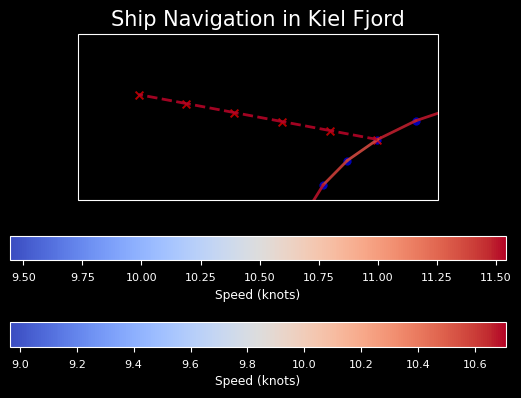

In [51]:
# num_predictions = 7
# start_pos = positions[0]
# positions_train, SOG_train, COG_train = positions[:-num_predictions], SOG[:-num_predictions], COG[:-num_predictions]
# positions_test, SOG_test, COG_test = positions[-num_predictions::], SOG[-num_predictions::], COG[-num_predictions::]

sog_pred, cog_pred, pos_pred = predict_kalman_new(SOG_train, COG_train, positions_train, num_predictions)

# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig, ax = plot_navigation(positions=positions, speeds=SOG, prediction=False) # Plot the actual navigation
plot_navigation(positions=pos_pred, speeds=sog_pred, prediction=True, fig=fig, ax=ax) # Plot the predicted navigation


In [ ]:
def predict_kalman_pos(POS: List[Tuple[float, float]], num_predictions: int, max_iter: int = 10) -> np.ndarray:
    """
    Predicts future states using the Kalman Filter algorithm.

    Args:
        start_pos (Tuple[float, float]): Starting position coordinates (latitude, longitude).
        num_predictions (int): Number of future state predictions to make.
        max_iter (int, optional): Maximum number of iterations for the EM algorithm. Defaults to 10.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Tuple containing the predicted Speed Over Ground, Course Over Ground, and positions.
    """
    
    ## Variables >>
    "EM algorithm is that the algorithm lacks regularization, meaning that parameter values may diverge to infinity in order to make the measurements more likely."
    "Thus it is important to choose which parameters to optimize via the em_vars parameter of KalmanFilter."
    em_vars=['transition_matrices', 'transition_covariance', 'observation_matrices', 'observation_covariance']
    measurements = np.asarray(POS)  # Convert positions to numpy array
    lat = measurements[:, 0]
    lon = measurements[:, 1]
    
    
    ## Initialize Kalman Filter >>
    initial_state_mean = [lat[0], lon[0]]
    transition_matrix = [[1, 0], [0, 1]]
    observation_matrix = [[1, 0], [0, 1]]
    
    kf = KalmanFilter(
        initial_state_mean=initial_state_mean,
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrix,
        n_dim_obs=2)  # n_dim_obs: number of observations space    
    
    ## Find the best number of iterations for the EM algorithm using the parameter change criterion >>
    best_n_iter = None
    best_parameter_change = float('inf')

    for n_iter in range(1, max_iter):
        # Perform the filtering and smoothing
        _kf = KalmanFilter(
            initial_state_mean=initial_state_mean,
            transition_matrices=transition_matrix,
            observation_matrices=observation_matrix,
            n_dim_obs=2)
        # _kf = _kf.em(measurements, n_iter=n_iter)
        _kf = _kf.em(measurements, n_iter=n_iter, em_vars=em_vars)
        smoothed_state_means, smoothed_state_covariances = _kf.smooth(measurements)
        filtered_state_means, filtered_state_covariances = _kf.filter(measurements)

        # Calculate the parameter change
        parameter_change = np.sum(np.abs(smoothed_state_means - filtered_state_means))

        # Check if this is the best fit so far
        if parameter_change < best_parameter_change:
            best_n_iter = n_iter
            best_parameter_change = parameter_change

    if best_n_iter is not None:
        print("Best n_iter:", best_n_iter)
    else:
        print("Best n_iter is None, using max_iter instead.")
        best_n_iter = max_iter
    
    
    ## Fit the Kalman Filter to the data with the best_n_iter >>
    # kf = kf.em(measurements, n_iter=best_n_iter)
    kf = kf.em(measurements, n_iter=5, em_vars=em_vars)  # n_iter: number of iterations or steps used in the expectation-maximization (EM) algorithm.
    (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    
    # Predict future states
    future_state_means, future_state_covariances = kf.filter_update(
        filtered_state_means[-1], filtered_state_covariances[-1])
    
    _predicted_lat = [lat[-1]]
    _predicted_lon = [lon[-1]]
    
    for _ in range(num_predictions):
        future_state_means, future_state_covariances = kf.filter_update(future_state_means, future_state_covariances)
        _predicted_lat.append(future_state_means[0])
        _predicted_lon.append(future_state_means[1])
    
    # Convert the lists into numpy arrays
    predicted_positions = np.array(list(zip(_predicted_lat, _predicted_lon))) # np.array(_predicted_positions[1::]) 
    
    return predicted_positions

In [ ]:
pos_pred = predict_kalman_pos(positions_train, num_predictions)

fig, ax = plot_navigation(positions=positions, prediction=False) # Plot the actual navigation
plot_navigation(positions=pos_pred, prediction=True) # Plot the predicted navigation


In [55]:
'''
====================================================
Applying the Kalman Filter with Missing Observations
====================================================

This example shows how one may apply :class:`KalmanFilter` when some
measurements are missing.

While the Kalman Filter and Kalman Smoother are typically presented assuming a
measurement exists for every time step, this is not always the case in reality.
:class:`KalmanFilter` is implemented to recognize masked portions of numpy
arrays as missing measurements.

The figure drawn illustrates the trajectory of each dimension of the true
state, the estimated state using all measurements, and the estimated state
using every fifth measurement.
'''
import numpy as np
import pylab as pl
from pykalman import KalmanFilter

# specify parameters
random_state = np.random.RandomState(0)
transition_matrix = [[1, 0.1], [0, 1]]
transition_offset = [-0.1, 0.1]
observation_matrix = np.eye(2) + random_state.randn(2, 2) * 0.1
observation_offset = [1.0, -1.0]
initial_state_mean = [5, -5]
n_timesteps = 50

# sample from model
kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    transition_offsets=transition_offset,
    observation_offsets=observation_offset,
    initial_state_mean=initial_state_mean,
    random_state=0
)
states, observations_all = kf.sample(
    n_timesteps, initial_state=initial_state_mean
)

# label half of the observations as missing
observations_missing = np.ma.array(
    observations_all,
    mask=np.zeros(observations_all.shape)
)
for t in range(n_timesteps):
    if t % 5 != 0:
        observations_missing[t] = np.ma.masked

# estimate state with filtering and smoothing
smoothed_states_all = kf.smooth(observations_all)[0]
smoothed_states_missing = kf.smooth(observations_missing)[0]

# draw estimates
pl.figure()
lines_true = pl.plot(states, color='b')
lines_smooth_all = pl.plot(smoothed_states_all, color='r')
lines_smooth_missing = pl.plot(smoothed_states_missing, color='g')
pl.legend(
    (lines_true[0], lines_smooth_all[0], lines_smooth_missing[0]),
    ('true', 'all', 'missing'),
    loc='lower right'
)
pl.show()

AttributeError: `newbyteorder` was removed from the ndarray class in NumPy 2.0. Use `arr.view(arr.dtype.newbyteorder(order))` instead.

In [54]:
data

{'n_timesteps': 501,
 'observations': masked_array(
   data=[[--, --],
         [-0.7102319164214306, -0.47950540432945654],
         [1.5275203506307378, -1.649932547333353],
         [3.6765530481517525, 3.0552104580083963],
         [8.287054494532342, -3.2487388554195684],
         [-5.0523085065379725, -4.86979027873619],
         [-22.461210082127256, 4.381591630577715],
         [-33.28440326693237, 17.792542246695636],
         [-43.519830979442126, 28.335542893483588],
         [-46.098737434630905, 30.304370109102397],
         [-49.663199873237296, 33.6786889248136],
         [-57.48180275874448, 40.411290780297605],
         [-60.48318528003433, 53.04521491498526],
         [-68.14734490990155, 54.373155642946074],
         [-73.77299968813917, 55.66791045897451],
         [-76.20096520864288, 56.06338723587989],
         [-80.55487146126276, 62.185060909511144],
         [-70.71806056087625, 66.16433441692196],
         [-78.24561791658863, 74.04395850041738],
         [-7

In [ ]:
positions[:-7]

In [ ]:
positions[-7::]

In [ ]:
pos_pred

In [ ]:
def kalman_filter_prediction(historical_data, t):
    """
    Predicts the future location, course over ground, and speed over ground of a ship using a Kalman Filter.

    Args:
    - historical_data: Multivariate time series containing historical ship's data.
    - t: Time in seconds for prediction.

    Returns:
    - Predicted location (latitude, longitude), course over ground, speed over ground, and confidence values.
    """
    # Initialize Kalman Filter
    kf = KalmanFilter(dim_x=3, dim_z=3)
    kf.x = np.array([historical_data[-1][:3]]).T
    kf.F = np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])
    kf.H = np.eye(3)
    kf.P *= 1000

    # Predict
    kf.predict()
    pred_state = kf.x
    pred_covariance = kf.P

    return pred_state, pred_covariance


### 1.3.3. <a id='toc1_3_3_'></a>[Extended Kalman Filter](#toc0_)

- Method: An extension of the Kalman Filter to nonlinear systems by linearizing the system dynamics and measurement functions.
- Pros:
    - Can handle nonlinear systems.
    - Generally more accurate than the standard KF for nonlinear systems.
- Cons:
    - Linearization may lead to inaccuracies, especially for highly nonlinear systems.
    - Computationally more expensive than the standard KF.


In [ ]:
def extended_kalman_filter_prediction(historical_data, t):
    """
    Predicts the future location, course over ground, and speed over ground of a ship using an Extended Kalman Filter.

    Args:
    - historical_data: Multivariate time series containing historical ship's data.
    - t: Time in seconds for prediction.

    Returns:
    - Predicted location (latitude, longitude), course over ground, speed over ground, and confidence values.
    """
    # Initialize Extended Kalman Filter
    ekf = ExtendedKalmanFilter(dim_x=3, dim_z=3)
    ekf.x = np.array([historical_data[-1][:3]]).T
    ekf.F = np.eye(3)
    ekf.H = np.eye(3)
    ekf.P *= 1000

    # Predict
    ekf.predict()
    pred_state = ekf.x
    pred_covariance = ekf.P

    return pred_state, pred_covariance



### 1.3.4. <a id='toc1_3_4_'></a>[Ensemble Kalman Filter](#toc0_)

[![GitLab issues by label](https://img.shields.io/badge/bug-11-red)](https://git.informatik.uni-kiel.de/gaf/enhanced-cpa/-/work_items/11)

 - Method: A variant of the Kalman Filter that approximates the state and covariance using an ensemble of samples instead of a single estimate.
 - Pros:
     - Can handle nonlinear systems without the need for linearization.
     - Suitable for problems where the system model is unknown or highly uncertain.
 - Cons:
     - Requires tuning of ensemble size and may suffer from sampling errors.
     - Can be computationally intensive, especially for high-dimensional systems.


In [ ]:
def ensemble_kalman_filter_prediction(historical_data, t):
    """
    Predicts the future location, course over ground, and speed over ground of a ship using an Ensemble Kalman Filter.

    Args:
    - historical_data: Multivariate time series containing historical ship's data.
    - t: Time in seconds for prediction.

    Returns:
    - Predicted location (latitude, longitude), course over ground, speed over ground, and confidence values.
    """
    # Initialize Ensemble Kalman Filter
    dt = 1.0  # time step
    N = 5  # ensemble size
    enkf = EnsembleKalmanFilter(dim_x=3, dim_z=3, N=N, dt=dt, hx=lambda x: x, fx=lambda x: x)
    enkf.x = np.array([historical_data[-1][:3]]).T
    enkf.F = np.eye(3)
    enkf.H = np.eye(3)
    enkf.P *= 1000

    # Predict
    enkf.predict()
    pred_state = enkf.x
    pred_covariance = enkf.P

    return pred_state, pred_covariance


### 1.3.5. <a id='toc1_3_5_'></a>[Unscented Kalman Filter](#toc0_)

[![GitLab issues by label](https://img.shields.io/badge/bug-12-red)](https://git.informatik.uni-kiel.de/gaf/enhanced-cpa/-/work_items/12)

- Method: Utilizes a deterministic sampling technique called the Unscented Transformation to capture the mean and covariance of the state distribution without linearization.
- Pros:
    - Accurate for nonlinear systems without the need for linearization.
    - Handles non-Gaussian noise distributions more effectively than the standard KF and EKF.
- Cons:
    - More complex than the standard KF and EKF.
    - Requires careful tuning of parameters like the scaling factor and sigma points selection.

In [ ]:

def unscented_kalman_filter_prediction(historical_data, t):
    """
    Predicts the future location, course over ground, and speed over ground of a ship using an Unscented Kalman Filter.

    Args:
    - historical_data: Multivariate time series containing historical ship's data.
    - t: Time in seconds for prediction.

    Returns:
    - Predicted location (latitude, longitude), course over ground, speed over ground, and confidence values.
    """
    # Initialize Unscented Kalman Filter
    ukf = UnscentedKalmanFilter(dim_x=3, dim_z=3, dt=1.0)
    ukf.x = np.array([historical_data[-1][:3]]).T
    ukf.F = np.eye(3)
    ukf.H = np.eye(3)
    ukf.P *= 1000

    # Predict
    ukf.predict()
    pred_state = ukf.x
    pred_covariance = ukf.P

    return pred_state, pred_covariance

### 1.3.6. <a id='toc1_3_6_'></a>[Example](#toc0_)

+ Generate Dependant Time Series Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of time steps
num_steps = 100

# Parameters for sine wave path
amplitude = 0.1  # Amplitude of the sine wave
frequency = 0.1  # Frequency of the sine wave (in cycles per time step)
period = 2 * np.pi / frequency  # Period of the sine wave

# Generate synthetic data for SOG and COG
sog = np.random.normal(loc=10, scale=2, size=num_steps)
cog = np.random.uniform(low=0, high=360, size=num_steps)

# Generate synthetic latitude and longitude based on sine wave path
time = np.arange(num_steps)
latitude = [initial_lat + amplitude * np.sin(2 * np.pi * frequency * t) for t in time]
longitude = [initial_lon + amplitude * np.cos(2 * np.pi * frequency * t) for t in time]

## Combine into a single dataset >>
data_sin = np.column_stack((latitude, longitude, sog, cog))

## Plot original data >>
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(latitude, label='Latitude')
plt.title('Sine Wave Path')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(longitude, label='Longitude')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sog, label='SOG')
plt.plot(cog, label='COG')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
## Generate synthetic data >>
np.random.seed(0)

# Number of time steps
num_steps = 100

# Initial latitude and longitude
initial_lat = 40
initial_lon = -75

# Generate synthetic data for SOG and COG
sog = np.random.normal(loc=10, scale=2, size=num_steps)
cog = np.random.uniform(low=0, high=360, size=num_steps)

# Generate synthetic latitude and longitude based on changes in SOG and COG
latitude = [initial_lat]
longitude = [initial_lon]

for i in range(1, num_steps):
    # Calculate change in latitude and longitude based on SOG and COG
    d_lat = sog[i] * np.cos(np.radians(cog[i])) / 111111  # Approximation for latitude (1 degree = 111111 meters)
    d_lon = sog[i] * np.sin(np.radians(cog[i])) / (111111 * np.cos(np.radians(initial_lat)))  # Approximation for longitude
    
    # Update latitude and longitude
    latitude.append(latitude[i-1] + d_lat)
    longitude.append(longitude[i-1] + d_lon)

## Combine into a single dataset >>
data_rnd = np.column_stack((latitude, longitude, sog, cog))

## Plot original data >>
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(latitude, label='Latitude')
plt.title('Original Data')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(longitude, label='Longitude')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sog, label='SOG')
plt.plot(cog, label='COG')
plt.legend()


+ Predict and plot

[![GitLab issues by label](https://img.shields.io/badge/bug-13-red)](https://git.informatik.uni-kiel.de/gaf/enhanced-cpa/-/work_items/13)

In [ ]:
# Define function to plot predicted values with confidence intervals
def plot_predictions_with_confidence(pred_states, pred_covariances, t):
    num_predictions = pred_states.shape[1]
    time_steps = np.arange(num_steps, num_steps + t)

    plt.figure(figsize=(12, 6))

    # Plot latitude
    plt.subplot(3, 1, 1)
    plt.plot(latitude, label='Latitude')
    for i in range(num_predictions):
        plt.plot(time_steps[i], pred_states[0, i], 'ro', alpha=0.3)
        plt.fill_between([time_steps[i]],
                         pred_states[0, i] - np.sqrt(pred_covariances[0, 0, i]),
                         pred_states[0, i] + np.sqrt(pred_covariances[0, 0, i]),
                         alpha=0.1)
    plt.title('Predicted Data with Confidence Intervals (Kalman Filter)')
    plt.legend()

    # Plot longitude
    plt.subplot(3, 1, 2)
    plt.plot(longitude, label='Longitude')
    for i in range(num_predictions):
        plt.plot(time_steps[i], pred_states[1, i], 'ro', alpha=0.3)
        plt.fill_between([time_steps[i]],
                         pred_states[1, i] - np.sqrt(pred_covariances[1, 1, i]),
                         pred_states[1, i] + np.sqrt(pred_covariances[1, 1, i]),
                         alpha=0.1)
    plt.legend()

    # # Plot SOG and COG
    # plt.subplot(3, 1, 3)
    # plt.plot(sog, label='SOG')
    # plt.plot(cog, label='COG')
    # plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Define time steps
t = 500  # Time for prediction (in seconds)
num_predictions = 50  # Number of prediction points

# Initialize arrays to store predicted states and covariances
pred_states = np.zeros((3, num_predictions))
pred_covariances = np.zeros((3, 3, num_predictions))

# Perform predictions for each time step
for i in range(num_predictions):
    # Predict future values using Kalman Filter
    kf_pred_state, kf_pred_covariance = kalman_filter_prediction(data_sin, t + i)
    
    # Store predicted state and covariance
    pred_states[:, i] = kf_pred_state.flatten()
    pred_covariances[:, :, i] = kf_pred_covariance

# Plot predicted values with confidence intervals
plot_predictions_with_confidence(pred_states, pred_covariances, t)